# Now we add noise.

Noise can be thought of as a regularizer to prevent overfitting. This makes sense - if the model only sees corrupted data, it can't tell what is good data and what is bad. If this is random, then it can't possible develop a strategy that is biased, so the best it can do is hedge. What does this mean for our setting?

In my paper we look at a signal pbit - these can be combined to make the kinds of signals we consider here.

# Scaling with number of signals.
In the last notebook, we saw that in general, given a reservoir computer, we can construct an exponential number of new signals that, generally, can be used to improve learning. First, we show this more carefully.These networks are simple enough that there are only a few parameters: Training data length, Reservoir size, Spectral radius, Sparsity, Regularization coefficient and Bleedthrough coefficient.

For this notebook, we are going to set 3,4,5 and 6 heuristically, and focus on 1 and 2. These can be tuned to control overfitting and performance. We also are going to optimize our simulation to have a batch dimension.

In [2]:
def fetchData(n):
    while True:
        u = 0.5 * np.random.uniform(low=0., high=1.0, size=(n+1000))
        freqs = [1, 3, 5]
        y = sum([np.sin(15*u) for freq in freqs])
        return (u, y)
        
def ESN_init(inSize, outSize, resSize, alpha, sparsity):
    Win = np.random.rand(inSize+1, resSize) - 0.5
    W = np.random.rand(resSize, resSize) - 0.5
    W[np.random.rand(resSize, resSize)>sparsity] = 0
    spec_rad = max(abs(np.linalg.eig(W)[0]))
    W /= spec_rad
    return Win, W, inSize, resSize, alpha, sparsity

# We're going to fix a very simple learning task - learning some collection of sinusoids. When considered as a signal processing tasks, this is simply learning the Fourier representation of a signal.

# In particular, we've assumed an n-gram model. The reservoir is performing a computational tasks that generally should involve reccurrence, but we will start without.

# Exhaustively using the power set is difficult, since the number of signals is exponential, but we can do it for small networks. 

In [45]:
def reservoir(data, Win, W, inSize, resSize, alpha, restart, batch_number, num_extra, power_set):
    device = torch.device("mps")
    batch_size = len(data) // batch_number
    W = torch.tensor(W).float()
    W = torch.tensor(W, device=device)
    data = torch.tensor(data).float()
    data = torch.tensor(data, device=device)
    new_data = data.view(batch_number, batch_size)
    W_copies = W.repeat(batch_number, 1, 1).float()
    Win = torch.tensor(Win).float()
    Win = torch.tensor(Win, device=device)
    Win_copies = Win.repeat(batch_number, 1, 1)
    R_copies = .1 * (torch.ones((batch_number, resSize), device=device) - 0.5).float()
    dm = torch.zeros((batch_number, batch_size - 50, 1 + inSize + resSize), device=device).float()
    for t in range(batch_size):
        u = new_data[:, t].unsqueeze(1)
        ones = torch.ones(u.shape[0], 1, device=device)
        ones = torch.hstack((ones, u))
        R_copies = (1 - alpha)*R_copies +\
        alpha*torch.tanh(torch.einsum('ij,ijk->ik', ones,Win_copies) +\
                  torch.einsum('ij,ijk->ik', R_copies, W_copies))
        u = u.float()
        if t >= 50:
            dm[:, t-50, :] = torch.cat((ones, R_copies), dim=1)            
    dm += torch.tensor(np.random.normal(scale=.05, size=dm.shape)).float().to(device)
    dm = dm.view(-1, 1+inSize+resSize)    
    new_data = new_data[:, 50:].flatten()
    s = list(dm.T)[2:]
    chosen_subsets = []
    if power_set:
        # Generate all subsets
        from itertools import combinations
        for subset_size in range(len(s)+1):  # +1 because range excludes the last number
            for subset in combinations(s, subset_size):
                chosen_subsets.append(list(subset))
    ones = torch.ones(new_data.shape[0]).numpy()
    chosen_subsets = [[l.cpu().numpy() for l in el] for el in chosen_subsets]
    power_signals = [reduce(lambda a, b: a*b, el, ones) for el in chosen_subsets] 
    power_signals = [torch.tensor(pw) for i,pw in enumerate(power_signals)]
    power_signals = [el.cpu() for el in list(dm.T)] + power_signals
    return torch.vstack(power_signals).T, new_data

## We simply add on all elements of the power set. Additionally we have rewritten the simulation to batch over the data dimension. 

In [35]:
def test_NARMA10(inSize=1, outSize=1, train_cycles=10000, test_cycles=1000, alpha=0.7, resSize=5,num_batches=2, powerset=False):    
    sparsity = 0.9
    Echo = ESN_init(inSize, outSize, resSize, alpha, sparsity)
    data, Y = fetchData(train_cycles+test_cycles + 50*num_batches*2)
    data_train, Y_train = data[:train_cycles+50*num_batches], Y[:train_cycles+50*num_batches]
    data_test, Y_test = data[train_cycles+50:], Y[train_cycles+50:]
    batch_size = len(data_train) // num_batches
    data_train, Y_train = data_train[:batch_size*num_batches], Y_train[:batch_size*num_batches]
   
    # Cut out the warmup portions.
    Y_train = Y_train.reshape((num_batches, batch_size))  
    Y_train = Y_train[:, 50:].flatten()
    num_extra = None
    RA_Train, data_train = reservoir(data_train, *Echo, num_batches, num_extra, powerset)
    ridge = np.zeros(tuple(RA_Train.shape))
    np.fill_diagonal(ridge, 1E-3) 
    Wout, _, _, _ = np.linalg.lstsq(RA_Train.cpu().float().numpy() + torch.tensor(ridge).float().numpy(), torch.tensor(Y_train).cpu().float().numpy(), rcond=0)
    plt.show()
    plt.plot(Wout, marker='x')
    plt.show()
    batch_size = len(data_test) // num_batches
    data_test, Y_test = data_test[:batch_size*num_batches], Y_test[:batch_size*num_batches]
    RA_Test, _ = reservoir(data_test, *Echo, num_batches, num_extra, powerset)
    Yhat = RA_Test.cpu() @ Wout
    
    Y_test = Y_test.reshape((num_batches, batch_size))  
    Y_test = Y_test[:, 50:].flatten()    
    NRMSE = np.sqrt(np.divide(np.mean(np.square(Y_test-Yhat.numpy().T)),np.var(Y_test)))
    return NRMSE, Y_test, Yhat, RA_Test



# Our first claim is that the power set signals help. This is trivially true, since it's strictly more signals, but since we are interested in a scaling law, we'd really like an ensemble over many reservoirs.

# It's challenging to even enforce monotonicity since the new neurons interact with the old ones. That being said, we can sample from an ensemble, and we find generally that the powerset does better.  (Intuitively, products of sines have side bands, and so we expect the product signals to help.)

# We include ridge regression to avoid overfitting and poor conditioning in the power set case.

Running 1.
1000


/var/folders/j0/gznjt10n4vsdfzmfxrnqn9hw0000gn/T/ipykernel_23832/2037202324.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = torch.tensor(W, device=device)
/var/folders/j0/gznjt10n4vsdfzmfxrnqn9hw0000gn/T/ipykernel_23832/2037202324.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, device=device)
/var/folders/j0/gznjt10n4vsdfzmfxrnqn9hw0000gn/T/ipykernel_23832/2037202324.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Win = torch.tensor(Win, device=device)


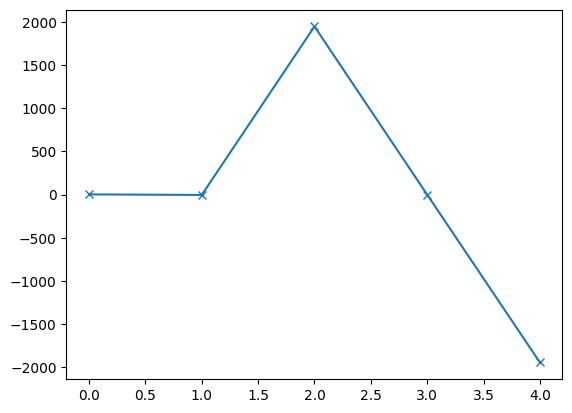

0.9380357654776589
2000


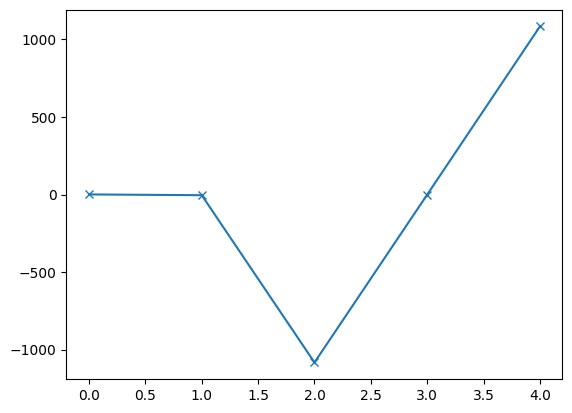

0.9410175671551354
Running 2.
1000
2000


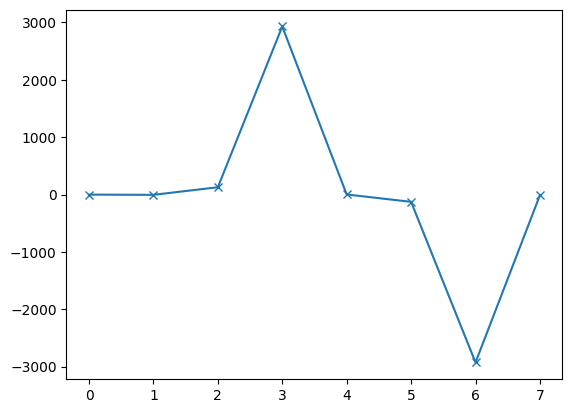

0.9368599960207895
3000


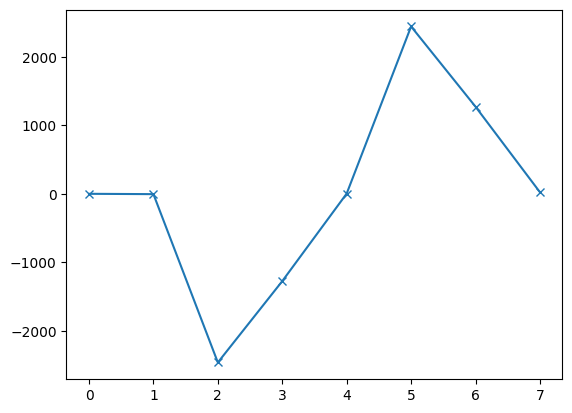

0.9370515062834102
Running 3.
1000
2000
3000


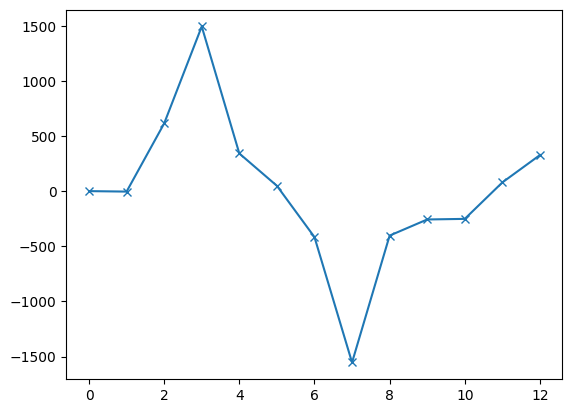

0.9386581401149833
Running 4.
1000
2000
3000


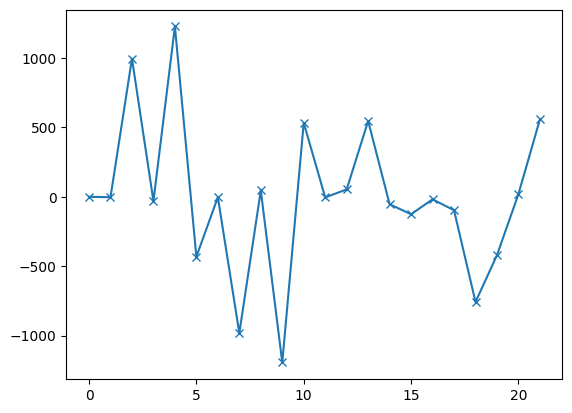

0.9197480272272542
4000


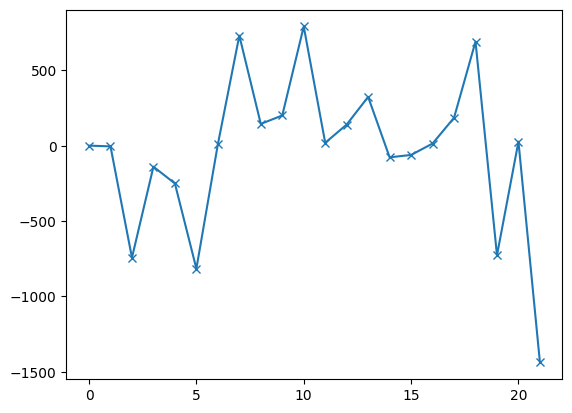

0.9266266029340077
Running 5.
1000
2000
3000
4000


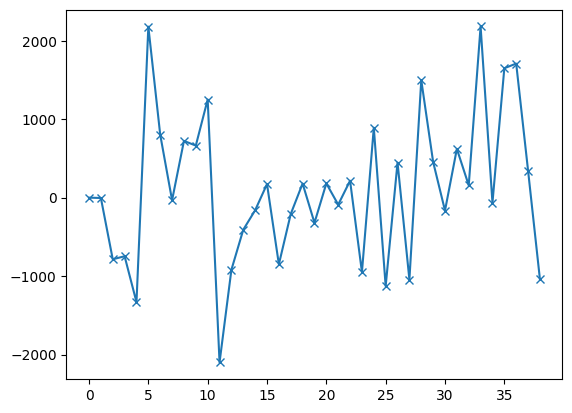

0.9358241885485917
Running 6.
1000
2000
3000
4000


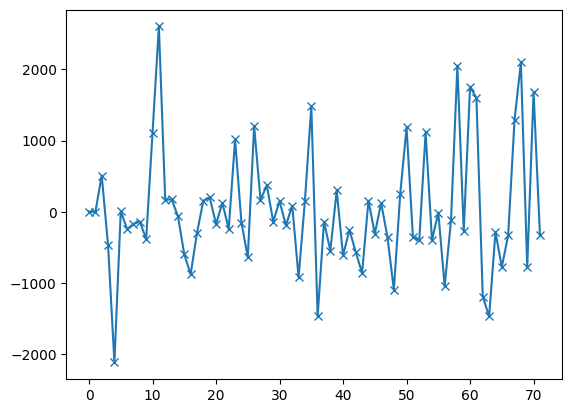

0.9423358821879692
Running 7.
1000
2000
3000
4000


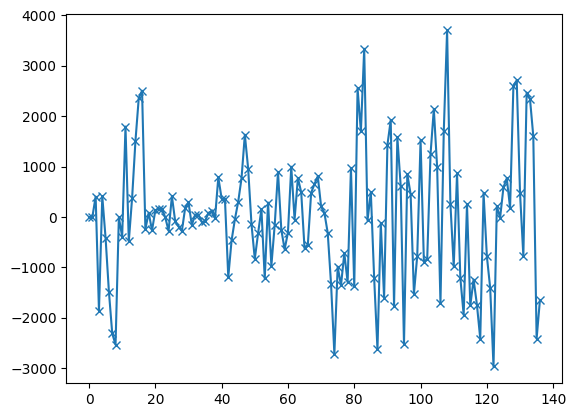

0.9050932352042514
5000


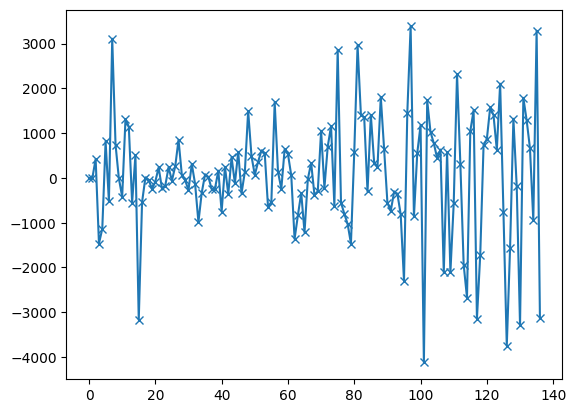

0.907493495153175
Running 8.
1000
2000
3000
4000
5000


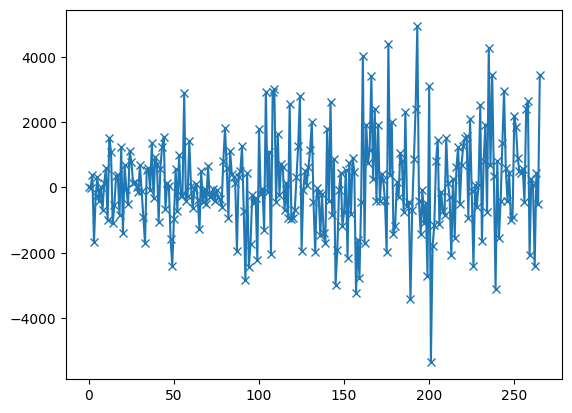

0.8726495779749782
6000


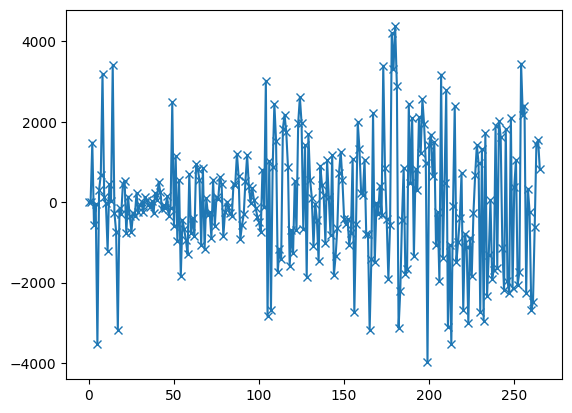

0.8801766919583891
Running 9.
1000
2000
3000
4000
5000
6000


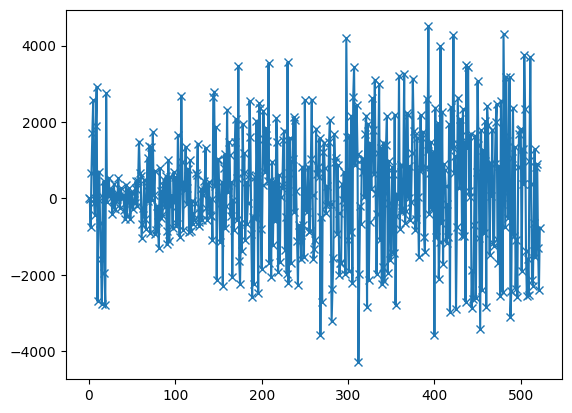

0.9070750383193104


In [37]:
import numpy as np
import torch, random
import matplotlib.pyplot as plt
import pickle
from functools import reduce
np.random.seed(137)
random.seed(137)
batches = 1000
test_cycles=1000
# list to store all NRMSE values
all_nrmse = []
spacingx=1
spacingy=1000
# range for resSize and train_cycles
resSizes = np.arange(1, 10, spacingx)
train_steps = np.arange(1000, 110000, spacingy)
last_train_cycles = 0
NRMSE = np.inf
powerset = True
# Demonstrated loop for different sizes and cycles
for resSize in resSizes:
    print(f"Running {resSize}.")
    for train_cycles in train_steps:
        print(train_cycles)
        if train_cycles < last_train_cycles:
            continue
        train_cycles = batches * train_cycles // batches
        NRMSE, _, _, _ = test_NARMA10(resSize=resSize, num_batches=batches, train_cycles=train_cycles, test_cycles=test_cycles, powerset=powerset)
        print(NRMSE)
        # Append the NRMSE value and configuration to the listpower
        all_nrmse.append((NRMSE, resSize, train_cycles))
        
        # Save results with pickle after each iteration
        with open(f'results{powerset}.pkl', 'wb') as f:
            pickle.dump(all_nrmse, f)

        # break loop if performance decreases
        if len(all_nrmse) > 1 and all_nrmse[-1][0] > all_nrmse[-2][0]:
            last_train_cycles = train_cycles
            break

# To keep things maneagble, we will only look up to 10 neurons. The power set is already 1024 signals large. We need to fight over training, as well as numerical error incurred in the power set, since naive mulitiplication produces exponentially small numbers.

In [38]:
# import numpy as np
# import torch, random
# import matplotlib.pyplot as plt
# import pickle
# from functools import reduce
# np.random.seed(137)
# random.seed(137)
# batches = 1000
# test_cycles=10000
# # list to store all NRMSE values
# all_nrmse = []
# spacingx=50
# spacingy=1000
# # range for resSize and train_cycles
# resSizes = np.arange(1, 1000, spacingx)
# train_steps = np.arange(100000, 1000000, spacingy)
# last_train_cycles = 0
# NRMSE = np.inf

# # Demonstrated loop for different sizes and cycles
# for resSize in resSizes:
#     print(f"Running {resSize}.")
#     for train_cycles in train_steps:
#         if train_cycles < last_train_cycles:
#             continue
#         train_cycles = batches * train_cycles // batches
#         print(train_cycles)
#         NRMSE, _, _, _ = test_NARMA10(resSize=resSize, num_batches=batches, train_cycles=train_cycles, test_cycles=test_cycles, pow_extra=1)
#         print(NRMSE)
#         # Append the NRMSE value and configuration to the list
#         all_nrmse.append((NRMSE, resSize, train_cycles))
        
#         # Save results with pickle after each iteration
#         with open('results1.pkl', 'wb') as f:
#             pickle.dump(all_nrmse, f)

#         # break loop if performance decreases
#         if len(all_nrmse) > 1 and all_nrmse[-1][0] > all_nrmse[-2][0]:
#             last_train_cycles = train_cycles
#             break

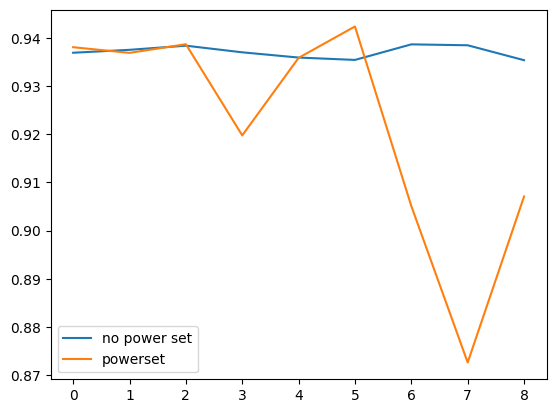

In [39]:
import pickle as pkl
import numpy as np
with open('resultsFalse.pkl', 'rb') as f:
    all_nrmse0 = pkl.load(f)
import numpy as np
with open('resultsTrue.pkl', 'rb') as f:
    all_nrmse1 = pkl.load(f)

a = np.array(all_nrmse0)
b = np.array(all_nrmse1)

import numpy as np
import matplotlib.pyplot as plt

def get_best_per_size(data):
    sizes = np.unique(data[:, 1])
    best_values = {}
    for size in sizes:
        size_data = data[data[:, 1] == size]
        best_value = np.min(size_data[:, 0])
        best_values[size] = best_value
    return best_values

# Find the best values per size for each dataset
best_a = get_best_per_size(a)
best_b = get_best_per_size(b)
plt.plot(list(best_a.values()), label='no power set')
plt.plot(list(best_b.values()), label='powerset')
plt.legend()

# Now, we include noise. First, this means we have to sample, and second, this changes the analytic form of the weight matrix.

# This is the analytic optimal solution. Now, we'll look over a wide variety of functions and see that this degradation is general - instead of having the exponential improvement, we merely have a linear improvement.

# Any noisy analog signal can be constructed from pbits, i.e. we are considering efficiently computable functions of Bernoulli random variables.

# Some computations are protected from noise - these are effectively digital, and not physical. We can't extract exponential utility from polynomial resources, even if we include an exponential amount of digital logic.

# We are generating the power set of outputs. So far, these are deterministic. Even with noise, one way for determinism is to take an infinite shot limit. If we consider noise, we can consider bernoulli noise, and then our space of 2^n functions that we produce acquires a probability distribution at each time step. That is, we previously had 2^n functions on 1 bit output each. We can equivalently consider 2^n functions on all n bit outputs. These are the probability distributions of the reservoir. Now, these have a particular noise model. At each step, we only get a sample from one of them.

# We consider analog, noisy distributions which can be decomposed into sums of bernoulli random variables, up to a desired accuracy.

In [341]:
def reservoir(data, Win, W, inSize, resSize, alpha, restart, batch_number, num_extra, power_set, noise):
    device = torch.device("mps")
    batch_size = len(data) // batch_number
    W = torch.tensor(W).float()
    W = torch.tensor(W, device=device)
    data = torch.tensor(data).float()
    data = torch.tensor(data, device=device)
    new_data = data.view(batch_number, batch_size)
    W_copies = W.repeat(batch_number, 1, 1).float()
    Win = torch.tensor(Win).float()
    Win = torch.tensor(Win, device=device)
    Win_copies = Win.repeat(batch_number, 1, 1)
    R_copies = .1 * (torch.ones((batch_number, resSize), device=device) - 0.5).float()
    dm = torch.zeros((batch_number, batch_size - 50, 1 + inSize + resSize), device=device).float()
    for t in range(batch_size):
        u = new_data[:, t].unsqueeze(1)
        ones = torch.ones(u.shape[0], 1, device=device)
        ones = torch.hstack((ones, u))
        R_copies = (1 - alpha)*R_copies +\
        alpha*torch.tanh(torch.einsum('ij,ijk->ik', ones,Win_copies) +\
                  torch.einsum('ij,ijk->ik', R_copies, W_copies))
        u = u.float()
        if t >= 50:
            dm[:, t-50, :] = torch.cat((ones, R_copies), dim=1)            
    if noise != 0:
        dm += torch.tensor(np.random.normal(scale=noise, size=dm.shape)).float().to(device)
    dm = dm.view(-1, 1+inSize+resSize)    
    new_data = new_data[:, 50:].flatten()
    s = list(dm.T)[2:]
    chosen_subsets = []
    if power_set:
        # Generate all subsets
        from itertools import combinations
        for subset_size in range(len(s)+1):  # +1 because range excludes the last number
            for subset in combinations(s, subset_size):
                chosen_subsets.append(list(subset))
    ones = torch.ones(new_data.shape[0]).numpy()
    chosen_subsets = [[l.cpu().numpy() for l in el] for el in chosen_subsets]
    power_signals = [reduce(lambda a, b: a*b, el, ones) for el in chosen_subsets] 
    power_signals = [torch.tensor(pw) for i,pw in enumerate(power_signals)]
    power_signals = [el.cpu() for el in list(dm.T)] + power_signals
    return torch.vstack(power_signals).T, new_data

In [342]:
def test_NARMA10(inSize=1, outSize=1, train_cycles=10000, test_cycles=1000, alpha=0.7, resSize=5,num_batches=2, powerset=False, noise=False):    
    sparsity = 0.9
    Echo = ESN_init(inSize, outSize, resSize, alpha, sparsity)
    num_extra = None
    num_samples = 1
    RA_Trains = []
    data, Y = fetchData(train_cycles+test_cycles + 50*num_batches*2)
    data_train, Y_train = data[:train_cycles+50*num_batches], Y[:train_cycles+50*num_batches]
    data_test, Y_test = data[train_cycles+50:], Y[train_cycles+50:]
    batch_size = len(data_train) // num_batches
    data_train, Y_train = data_train[:batch_size*num_batches], Y_train[:batch_size*num_batches]

    # Cut out the warmup portions.
    Y_train = Y_train.reshape((num_batches, batch_size))  
    Y_train = Y_train[:, 50:].flatten()
    for _ in range(num_samples):
        RA_Train, _ = reservoir(data_train, *Echo, num_batches, num_extra, powerset, noise)
        RA_Trains.append(RA_Train)
    RA_Trains = np.array(RA_Trains)
    XX = torch.tensor(np.zeros((RA_Trains.shape[2],RA_Trains.shape[2])))
    for t in range(RA_Trains.shape[1]):
        XX += RA_Trains[:,t,:].T.dot(RA_Trains[:,t,:])/num_samples/RA_Trains.shape[1]
    YY = np.average(RA_Trains, axis=0).T.dot(Y_train)/RA_Trains.shape[1]
    coeff = 1E-6
    ridge = np.zeros(XX.shape)
    np.fill_diagonal(ridge, coeff)   
    Wout, _, _, _ = np.linalg.lstsq(XX.cpu().float().numpy() + torch.tensor(ridge).float().numpy(), torch.tensor(YY).cpu().float().numpy(), rcond=0)

    batch_size = len(data_test) // num_batches
    data_test, Y_test = data_test[:batch_size*num_batches], Y_test[:batch_size*num_batches]
    RA_Test, _ = reservoir(data_test, *Echo, num_batches, num_extra, powerset, noise)
    Yhat = RA_Test.cpu() @ Wout
    
    Y_test = Y_test.reshape((num_batches, batch_size))  
    Y_test = Y_test[:, 50:].flatten()    
    NRMSE = np.sqrt(np.divide(np.mean(np.square(Y_test-Yhat.numpy().T)),np.var(Y_test)))
    return NRMSE, Y_test, Yhat, RA_Test



In [343]:
import numpy as np
import torch, random
import matplotlib.pyplot as plt
import pickle
from functools import reduce
for powerset in [True, False]:
    for noise in [.01, 0]:
        np.random.seed(137)
        random.seed(137)
        batches = 1000
        test_cycles=1000
        # list to store all NRMSE values
        all_nrmse = []
        spacingx=1
        spacingy=1000
        # range for resSize and train_cycles
        resSizes = np.arange(1, 10, spacingx)
        train_steps = np.arange(1000, 110000, spacingy)
        last_train_cycles = 0
        NRMSE = np.inf
        # Demonstrated loop for different sizes and cycles
        for resSize in resSizes:
            print(f"Running {resSize}.")
            for train_cycles in train_steps:
                print(train_cycles)
                if train_cycles < last_train_cycles:
                    continue
                train_cycles = batches * train_cycles // batches
                NRMSE, _, _, _ = test_NARMA10(resSize=resSize, num_batches=batches, train_cycles=train_cycles, test_cycles=test_cycles, powerset=powerset, noise=noise)
                print(NRMSE)
                # Append the NRMSE value and configuration to the listpower
                all_nrmse.append((NRMSE, resSize, train_cycles))

                # Save results with pickle after each iteration
                with open(f'results{powerset}{noise}.pkl', 'wb') as f:
                    pickle.dump(all_nrmse, f)

                # break loop if performance decreases
                if len(all_nrmse) > 1 and all_nrmse[-1][0] > all_nrmse[-2][0]:
                    last_train_cycles = train_cycles
                    break

Running 1.
1000


/var/folders/j0/gznjt10n4vsdfzmfxrnqn9hw0000gn/T/ipykernel_23832/2963260526.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = torch.tensor(W, device=device)
/var/folders/j0/gznjt10n4vsdfzmfxrnqn9hw0000gn/T/ipykernel_23832/2963260526.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, device=device)
/var/folders/j0/gznjt10n4vsdfzmfxrnqn9hw0000gn/T/ipykernel_23832/2963260526.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Win = torch.tensor(Win, device=device)


0.9294633628936176
2000
0.9330110104415751
Running 2.
1000
2000
0.9211021315760642
3000
0.9274482175084694
Running 3.
1000
2000
3000
0.9294898037426118
Running 4.
1000
2000
3000
0.8380077357535269
4000
0.8532795830817869
Running 5.
1000
2000
3000
4000
0.9001507997177391
Running 6.
1000
2000
3000
4000
0.9142278243049621
Running 7.
1000
2000
3000
4000
0.7774248837787858
5000
0.7735760302659358
6000
0.7855512991280391
Running 8.
1000
2000
3000
4000
5000
6000
0.7606013903626867
7000
0.773732970957658
Running 9.
1000
2000
3000
4000
5000
6000
7000
0.7813677886425635
Running 1.
1000
0.9274798631813402
2000
0.9339375008167724
Running 2.
1000
2000
0.9312686920506439
3000
0.9093840342904295
4000
0.9264328955560044
Running 3.
1000
2000
3000
4000
0.9026141024939025
5000
0.9147655701988592
Running 4.
1000
2000
3000
4000
5000
0.8675169975762737
6000
0.8670046113381623
7000
0.772869444423943
8000
0.8216567637185934
Running 5.
1000
2000
3000
4000
5000
6000
7000
8000
0.8184811567032918
9000
0.753882493

In [346]:
%ls

1696456938_results.pkl
1696457659_results.pkl
1696457715_results.pkl
Blog/
ESN.ipynb
ESN.py
ESN_test.py
Got Torch Working, Final.ipynb
LICENSE
Limits To Reservoir Learning Parallel Torch.ipynb
Limits To Reservoir Learning Parallel.ipynb
Limits to Reservoir Learning 1.ipynb
Limits to Reservoir Learning 2.ipynb
Limits to Reservoir Learning 3.ipynb
Limits to Reservoir Learning Debug more signals.ipynb
Limits to Reservoir Learning Final.ipynb
Limits to Reservoir Learning Old.ipynb
Limits to Reservoir Learning Scratch.ipynb
Limits to Reservoir Learning-New.ipynb
NARMA10.py
Numpy v. Torch.ipynb
README.md
Untitled.ipynb
__init__.py
__pycache__/
csv_files/
images/
ra.pkl
results.pkl
results0.pkl
results1.5.pkl
results1.pkl
results15.pkl
results2.5.pkl
results2.pkl
results3.pkl
resultsFalse.pkl
resultsFalse0.01.pkl
resultsFalse0.pkl
resultsFalseFalse.pkl
resultsFalseTrue.pkl
resultsTrue.pkl
resultsTrue0.01.pkl
resultsTrue0.pkl
resultsTrueFalse.pkl
resultsTrueTrue.pkl
resultsdouble.pkl
resultsli

# Noise .01

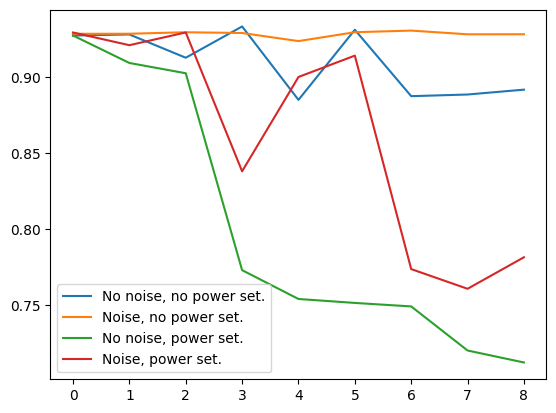

In [347]:
import pickle as pkl
import numpy as np
with open('resultsFalse0.pkl', 'rb') as f:
    all_nrmse0 = pkl.load(f)
with open('resultsFalse0.01.pkl', 'rb') as f:
    all_nrmse1 = pkl.load(f)
with open('resultsTrue0.pkl', 'rb') as f:
    all_nrmse2 = pkl.load(f)
with open('resultsTrue0.01.pkl', 'rb') as f:
    all_nrmse3 = pkl.load(f)

a = np.array(all_nrmse0)
b = np.array(all_nrmse1)
c = np.array(all_nrmse2)
d = np.array(all_nrmse3)


import numpy as np
import matplotlib.pyplot as plt

def get_best_per_size(data):
    sizes = np.unique(data[:, 1])
    best_values = {}
    for size in sizes:
        size_data = data[data[:, 1] == size]
        best_value = np.min(size_data[:, 0])
        best_values[size] = best_value
    return best_values

# Find the best values per size for each dataset
best_a = get_best_per_size(a)
best_b = get_best_per_size(b)
best_c = get_best_per_size(c)
best_d = get_best_per_size(d)

plt.plot(list(best_a.values()), label='No noise, no power set.')
plt.plot(list(best_b.values()), label='Noise, no power set.')
plt.plot(list(best_c.values()), label='No noise, power set.')
plt.plot(list(best_d.values()), label='Noise, power set.')
plt.legend()

# Noise = .05

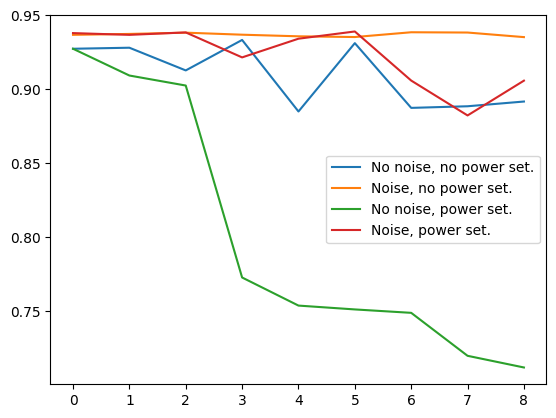

In [340]:
import pickle as pkl
import numpy as np
with open('resultsFalseFalse.pkl', 'rb') as f:
    all_nrmse0 = pkl.load(f)
with open('resultsFalseTrue.pkl', 'rb') as f:
    all_nrmse1 = pkl.load(f)
with open('resultsTrueFalse.pkl', 'rb') as f:
    all_nrmse2 = pkl.load(f)
with open('resultsTrueTrue.pkl', 'rb') as f:
    all_nrmse3 = pkl.load(f)

a = np.array(all_nrmse0)
b = np.array(all_nrmse1)
c = np.array(all_nrmse2)
d = np.array(all_nrmse3)


import numpy as np
import matplotlib.pyplot as plt

def get_best_per_size(data):
    sizes = np.unique(data[:, 1])
    best_values = {}
    for size in sizes:
        size_data = data[data[:, 1] == size]
        best_value = np.min(size_data[:, 0])
        best_values[size] = best_value
    return best_values

# Find the best values per size for each dataset
best_a = get_best_per_size(a)
best_b = get_best_per_size(b)
best_c = get_best_per_size(c)
best_d = get_best_per_size(d)

plt.plot(list(best_a.values()), label='No noise, no power set.')
plt.plot(list(best_b.values()), label='Noise, no power set.')
plt.plot(list(best_c.values()), label='No noise, power set.')
plt.plot(list(best_d.values()), label='Noise, power set.')
plt.legend()

# numerically unstable for a single shot? 
# Also, look how much noise hurts or rather, how little the power set helps with noise!

In [348]:
def reservoir(data, Win, W, inSize, resSize, alpha, restart, batch_number, num_extra, power_set, noise):
    device = torch.device("mps")
    batch_size = len(data) // batch_number
    W = torch.tensor(W).float()
    W = torch.tensor(W, device=device)
    data = torch.tensor(data).float()
    data = torch.tensor(data, device=device)
    new_data = data.view(batch_number, batch_size)
    W_copies = W.repeat(batch_number, 1, 1).float()
    Win = torch.tensor(Win).float()
    Win = torch.tensor(Win, device=device)
    Win_copies = Win.repeat(batch_number, 1, 1)
    R_copies = .1 * (torch.ones((batch_number, resSize), device=device) - 0.5).float()
    dm = torch.zeros((batch_number, batch_size - 50, 1 + inSize + resSize), device=device).float()
    for t in range(batch_size):
        u = new_data[:, t].unsqueeze(1)
        ones = torch.ones(u.shape[0], 1, device=device)
        ones = torch.hstack((ones, u))
        R_copies = (1 - alpha)*R_copies +\
        alpha*torch.tanh(torch.einsum('ij,ijk->ik', ones,Win_copies) +\
                  torch.einsum('ij,ijk->ik', R_copies, W_copies))
        u = u.float()
        if t >= 50:
            dm[:, t-50, :] = torch.cat((ones, R_copies), dim=1)            
    if noise != 0:
        dm += torch.tensor(np.random.normal(scale=noise, size=dm.shape)).float().to(device)
    dm = dm.view(-1, 1+inSize+resSize)    
    new_data = new_data[:, 50:].flatten()
    s = list(dm.T)[2:]
    chosen_subsets = []
    if power_set:
        # Generate all subsets
        from itertools import combinations
        for subset_size in range(len(s)+1):  # +1 because range excludes the last number
            for subset in combinations(s, subset_size):
                chosen_subsets.append(list(subset))
    ones = torch.ones(new_data.shape[0]).numpy()
    chosen_subsets = [[l.cpu().numpy() for l in el] for el in chosen_subsets]
    power_signals = [reduce(lambda a, b: a*b, el, ones) for el in chosen_subsets] 
    power_signals = [torch.tensor(pw) for i,pw in enumerate(power_signals)]
    power_signals = [el.cpu() for el in list(dm.T)] + power_signals
    return torch.vstack(power_signals).T, new_data

In [359]:
def test_NARMA10(inSize=1, outSize=1, train_cycles=10000, test_cycles=1000, alpha=0.7, resSize=5,num_batches=2, powerset=False, noise=False):    
    sparsity = 0.9
    Echo = ESN_init(inSize, outSize, resSize, alpha, sparsity)
    num_extra = None
    num_samples = 20
    RA_Trains = []
    data, Y = fetchData(train_cycles+test_cycles + 50*num_batches*2)
    data_train, Y_train = data[:train_cycles+50*num_batches], Y[:train_cycles+50*num_batches]
    data_test, Y_test = data[train_cycles+50:], Y[train_cycles+50:]
    batch_size = len(data_train) // num_batches
    data_train, Y_train = data_train[:batch_size*num_batches], Y_train[:batch_size*num_batches]

    # Cut out the warmup portions.
    Y_train = Y_train.reshape((num_batches, batch_size))  
    Y_train = Y_train[:, 50:].flatten()
    for _ in range(num_samples):
        RA_Train, _ = reservoir(data_train, *Echo, num_batches, num_extra, powerset, noise)
        RA_Trains.append(RA_Train)
    RA_Trains = np.array(RA_Trains)
    XX = torch.tensor(np.zeros((RA_Trains.shape[2],RA_Trains.shape[2])))
    for t in range(RA_Trains.shape[1]):
        XX += RA_Trains[:,t,:].T.dot(RA_Trains[:,t,:])/num_samples/RA_Trains.shape[1]
    YY = np.average(RA_Trains, axis=0).T.dot(Y_train)/RA_Trains.shape[1]
    coeff = 1E-6
    ridge = np.zeros(XX.shape)
    np.fill_diagonal(ridge, coeff)   
    Wout, _, _, _ = np.linalg.lstsq(XX.cpu().float().numpy() + torch.tensor(ridge).float().numpy(), torch.tensor(YY).cpu().float().numpy(), rcond=0)

    batch_size = len(data_test) // num_batches
    data_test, Y_test = data_test[:batch_size*num_batches], Y_test[:batch_size*num_batches]
    RA_Test, _ = reservoir(data_test, *Echo, num_batches, num_extra, powerset, noise)
    Yhat = RA_Test.cpu() @ Wout
    
    Y_test = Y_test.reshape((num_batches, batch_size))  
    Y_test = Y_test[:, 50:].flatten()    
    NRMSE = np.sqrt(np.divide(np.mean(np.square(Y_test-Yhat.numpy().T)),np.var(Y_test)))
    return NRMSE, Y_test, Yhat, RA_Test



# 20 samples 

In [360]:
import numpy as np
import torch, random
import matplotlib.pyplot as plt
import pickle
from functools import reduce
from tqdm import tqdm

noises = [.01, 0]
for noise in tqdm(noises):
    for powerset in [True, False]:
        np.random.seed(137)
        random.seed(137)
        batches = 1000
        test_cycles=1000
        # list to store all NRMSE values
        all_nrmse = []
        spacingx=1
        spacingy=1000
        # range for resSize and train_cycles
        resSizes = np.arange(1, 10, spacingx)
        train_steps = np.arange(1000, 110000, spacingy)
        last_train_cycles = 0
        NRMSE = np.inf
        # Demonstrated loop for different sizes and cycles
        for resSize in resSizes:
            print(f"Running {resSize}.")
            for train_cycles in train_steps:
                if train_cycles < last_train_cycles:
                    continue
                train_cycles = batches * train_cycles // batches
                NRMSE, _, _, _ = test_NARMA10(resSize=resSize, num_batches=batches, train_cycles=train_cycles, test_cycles=test_cycles, powerset=powerset, noise=noise)
                print(NRMSE)
                # Append the NRMSE value and configuration to the listpower
                all_nrmse.append((NRMSE, resSize, train_cycles))

                # Save results with pickle after each iteration
                with open(f'results{powerset}{noise}.pkl', 'wb') as f:
                    pickle.dump(all_nrmse, f)

                # break loop if performance decreases
                if len(all_nrmse) > 1 and all_nrmse[-1][0] > all_nrmse[-2][0]:
                    last_train_cycles = train_cycles
                    break

  0%|                                                     | 0/2 [00:00<?, ?it/s]/var/folders/j0/gznjt10n4vsdfzmfxrnqn9hw0000gn/T/ipykernel_23832/2963260526.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = torch.tensor(W, device=device)
/var/folders/j0/gznjt10n4vsdfzmfxrnqn9hw0000gn/T/ipykernel_23832/2963260526.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, device=device)
/var/folders/j0/gznjt10n4vsdfzmfxrnqn9hw0000gn/T/ipykernel_23832/2963260526.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Win

Running 1.
0.9281680177813976
0.9284097872703402
Running 2.
0.8910218982871306
0.8512943290793036
0.9313059076681384
Running 3.
0.8458573800511952
0.9055648807290235
Running 4.
0.8280990067062916
0.8420290552266924
Running 5.
0.838033441105929
0.8407892892689445
Running 6.
0.8344607155130922
0.8549907386566163
Running 7.
0.8622951855646662
Running 8.
0.8223856753472079
0.7765046384369186
0.7795670966834051
Running 9.
0.744637260427217
0.7082834932896453
0.7581557881172735
Running 1.
0.9283655343380732
0.9284075153123245
Running 2.
0.9295689328452259
Running 3.
0.9293979846804222
0.9317892521831075
Running 4.
0.9290537304054894
0.930376669863221
Running 5.
0.9301753082825658
0.9280081626129972
0.9282714019617001
Running 6.
0.9309570027886968
Running 7.
0.9313546892408499
Running 8.
0.927865744369941
0.9287728389399201
Running 9.


 50%|██████████████████████                      | 1/2 [02:38<02:38, 158.19s/it]

0.9314815869113099
Running 1.
0.9274801634811279
0.9339375272602304
Running 2.
0.9312687864107335
0.9093840342904295
0.9264328891320139
Running 3.
0.9026141007206057
0.9147655753468945
Running 4.
0.8675185180406182
0.8670046857055731
0.7728741311164
0.8216153693812266
Running 5.
0.8184987066624443
0.7538803526201318
0.8199975792699168
Running 6.
0.8034624467701921
0.788344918345432
0.7834593133273404
0.7512907165157559
0.8691467671398079
Running 7.
0.7980298125786832
0.7702159142337466
0.7611778417643204
0.7489818983559581
0.7503845265819227
Running 8.
0.7199397004750064
0.7635182351104104
Running 9.
0.753226469404353
0.7120547050733682
0.7490438982462797
Running 1.
0.9274745566901965
0.9339011677820922
Running 2.
0.9332790671576645
0.9318390533650187
0.9281735951508268
0.9288200343076489
Running 3.
0.9128338239595477
0.9305070573902795
Running 4.
0.9334297089671663
Running 5.
0.8850734120117436
0.9294925230077952
Running 6.
0.93126948957962
Running 7.
0.8875110625314808
0.905367992335

100%|████████████████████████████████████████████| 2/2 [06:31<00:00, 195.80s/it]

0.8943135601012707


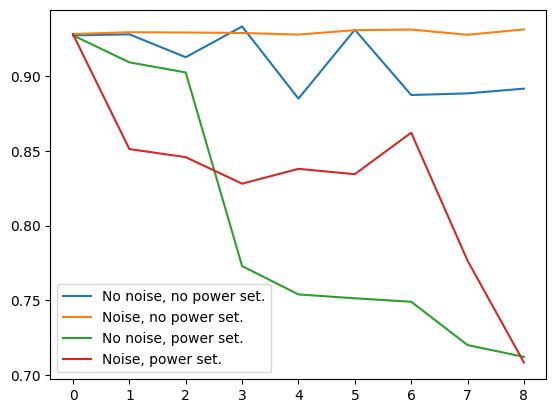

In [361]:
import pickle as pkl
import numpy as np
with open('resultsFalse0.pkl', 'rb') as f:
    all_nrmse0 = pkl.load(f)
with open('resultsFalse0.01.pkl', 'rb') as f:
    all_nrmse1 = pkl.load(f)
with open('resultsTrue0.pkl', 'rb') as f:
    all_nrmse2 = pkl.load(f)
with open('resultsTrue0.01.pkl', 'rb') as f:
    all_nrmse3 = pkl.load(f)

a = np.array(all_nrmse0)
b = np.array(all_nrmse1)
c = np.array(all_nrmse2)
d = np.array(all_nrmse3)


import numpy as np
import matplotlib.pyplot as plt

def get_best_per_size(data):
    sizes = np.unique(data[:, 1])
    best_values = {}
    for size in sizes:
        size_data = data[data[:, 1] == size]
        best_value = np.min(size_data[:, 0])
        best_values[size] = best_value
    return best_values

# Find the best values per size for each dataset
best_a = get_best_per_size(a)
best_b = get_best_per_size(b)
best_c = get_best_per_size(c)
best_d = get_best_per_size(d)

plt.plot(list(best_a.values()), label='No noise, no power set.')
plt.plot(list(best_b.values()), label='Noise, no power set.')
plt.plot(list(best_c.values()), label='No noise, power set.')
plt.plot(list(best_d.values()), label='Noise, power set.')
plt.legend()

# 10 samples

In [355]:
import numpy as np
import torch, random
import matplotlib.pyplot as plt
import pickle
from functools import reduce
from tqdm import tqdm

noises = [.01, 0]
for noise in tqdm(noises):
    for powerset in [True, False]:
        np.random.seed(137)
        random.seed(137)
        batches = 1000
        test_cycles=1000
        # list to store all NRMSE values
        all_nrmse = []
        spacingx=1
        spacingy=1000
        # range for resSize and train_cycles
        resSizes = np.arange(1, 10, spacingx)
        train_steps = np.arange(1000, 110000, spacingy)
        last_train_cycles = 0
        NRMSE = np.inf
        # Demonstrated loop for different sizes and cycles
        for resSize in resSizes:
            print(f"Running {resSize}.")
            for train_cycles in train_steps:
                if train_cycles < last_train_cycles:
                    continue
                train_cycles = batches * train_cycles // batches
                NRMSE, _, _, _ = test_NARMA10(resSize=resSize, num_batches=batches, train_cycles=train_cycles, test_cycles=test_cycles, powerset=powerset, noise=noise)
                print(NRMSE)
                # Append the NRMSE value and configuration to the listpower
                all_nrmse.append((NRMSE, resSize, train_cycles))

                # Save results with pickle after each iteration
                with open(f'results{powerset}{noise}.pkl', 'wb') as f:
                    pickle.dump(all_nrmse, f)

                # break loop if performance decreases
                if len(all_nrmse) > 1 and all_nrmse[-1][0] > all_nrmse[-2][0]:
                    last_train_cycles = train_cycles
                    break

  0%|                                                     | 0/2 [00:00<?, ?it/s]/var/folders/j0/gznjt10n4vsdfzmfxrnqn9hw0000gn/T/ipykernel_23832/2963260526.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = torch.tensor(W, device=device)
/var/folders/j0/gznjt10n4vsdfzmfxrnqn9hw0000gn/T/ipykernel_23832/2963260526.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, device=device)
/var/folders/j0/gznjt10n4vsdfzmfxrnqn9hw0000gn/T/ipykernel_23832/2963260526.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Win

Running 1.
0.9285966186609114
0.9299881404086252
Running 2.
0.9298447525756762
0.9255907981382077
0.9292431840959171
Running 3.
0.831103932463677
0.9153138206318143
Running 4.
0.8281746019381001
0.8067569867530427
0.8267668637034485
Running 5.
0.8122020926509929
0.8173782264339599
Running 6.
0.8104937143893994
0.7966832247221765
0.8034180623578758
Running 7.
0.7679189620981519
0.8223164274622922
Running 8.
0.8287494732880049
Running 9.
0.7309450846363766
0.8112751195125857
Running 1.
0.9287048444017737
0.9300292229267166
Running 2.
0.9300589133011009
Running 3.
0.9311323063654278
Running 4.
0.932285963989271
Running 5.
0.9310389357683678
0.9297980429812231
0.9299727045506817
Running 6.
0.9311011437806637
Running 7.
0.9288882195411188
0.9295774542196844
Running 8.
0.9291337487257637
0.9278136949729708
0.9295314469195627
Running 9.


 50%|██████████████████████▌                      | 1/2 [01:25<01:25, 85.71s/it]

0.931290782391189
Running 1.
0.9274798631813402
0.933937518435882
Running 2.
0.9312686950305278
0.9093840342904295
0.9264328955560044
Running 3.
0.9026141022496864
0.9147655612729441
Running 4.
0.8675169835787147
0.8670045566965324
0.7728738873884743
0.8216567637185934
Running 5.
0.818479324593062
0.7538782035982285
0.8199973038210406
Running 6.
0.8034624700450006
0.7883753710854996
0.7834589250551605
0.7512875867292521
0.8691438283219943
Running 7.
0.7980310613007371
0.7702300338187892
0.7611680064379384
0.7489817898906671
0.7503855845391431
Running 8.
0.7199396978667851
0.7635182925509348
Running 9.
0.7532348623445774
0.7120518788955325
0.749045217399906
Running 1.
0.9274741992459051
0.933901167080449
Running 2.
0.9332790307094192
0.9318390533650187
0.928173596072392
0.9288200347228136
Running 3.
0.9128171321169465
0.9305070865748984
Running 4.
0.9334290175948469
Running 5.
0.8850734120117436
0.9294925229205495
Running 6.
0.9312695318759165
Running 7.
0.8875110395095055
0.90536831417

100%|████████████████████████████████████████████| 2/2 [04:00<00:00, 120.25s/it]

0.8943191909267552


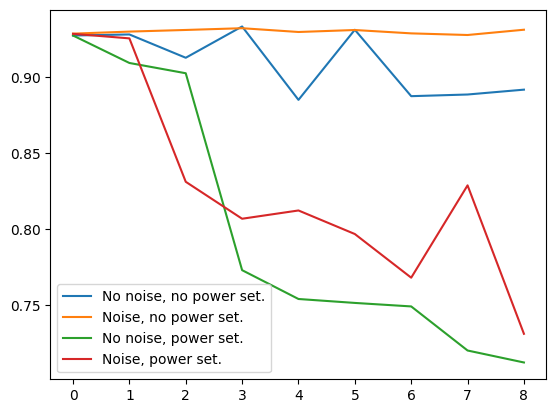

In [356]:
import pickle as pkl
import numpy as np
with open('resultsFalse0.pkl', 'rb') as f:
    all_nrmse0 = pkl.load(f)
with open('resultsFalse0.01.pkl', 'rb') as f:
    all_nrmse1 = pkl.load(f)
with open('resultsTrue0.pkl', 'rb') as f:
    all_nrmse2 = pkl.load(f)
with open('resultsTrue0.01.pkl', 'rb') as f:
    all_nrmse3 = pkl.load(f)

a = np.array(all_nrmse0)
b = np.array(all_nrmse1)
c = np.array(all_nrmse2)
d = np.array(all_nrmse3)


import numpy as np
import matplotlib.pyplot as plt

def get_best_per_size(data):
    sizes = np.unique(data[:, 1])
    best_values = {}
    for size in sizes:
        size_data = data[data[:, 1] == size]
        best_value = np.min(size_data[:, 0])
        best_values[size] = best_value
    return best_values

# Find the best values per size for each dataset
best_a = get_best_per_size(a)
best_b = get_best_per_size(b)
best_c = get_best_per_size(c)
best_d = get_best_per_size(d)

plt.plot(list(best_a.values()), label='No noise, no power set.')
plt.plot(list(best_b.values()), label='Noise, no power set.')
plt.plot(list(best_c.values()), label='No noise, power set.')
plt.plot(list(best_d.values()), label='Noise, power set.')
plt.legend()

# 1 sample

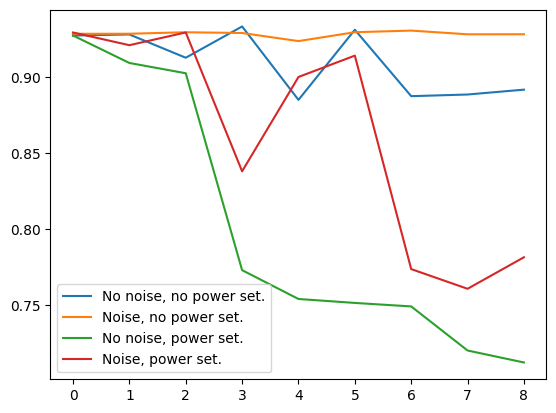

In [353]:
import pickle as pkl
import numpy as np
with open('resultsFalse0.pkl', 'rb') as f:
    all_nrmse0 = pkl.load(f)
with open('resultsFalse0.01.pkl', 'rb') as f:
    all_nrmse1 = pkl.load(f)
with open('resultsTrue0.pkl', 'rb') as f:
    all_nrmse2 = pkl.load(f)
with open('resultsTrue0.01.pkl', 'rb') as f:
    all_nrmse3 = pkl.load(f)

a = np.array(all_nrmse0)
b = np.array(all_nrmse1)
c = np.array(all_nrmse2)
d = np.array(all_nrmse3)


import numpy as np
import matplotlib.pyplot as plt

def get_best_per_size(data):
    sizes = np.unique(data[:, 1])
    best_values = {}
    for size in sizes:
        size_data = data[data[:, 1] == size]
        best_value = np.min(size_data[:, 0])
        best_values[size] = best_value
    return best_values

# Find the best values per size for each dataset
best_a = get_best_per_size(a)
best_b = get_best_per_size(b)
best_c = get_best_per_size(c)
best_d = get_best_per_size(d)

plt.plot(list(best_a.values()), label='No noise, no power set.')
plt.plot(list(best_b.values()), label='Noise, no power set.')
plt.plot(list(best_c.values()), label='No noise, power set.')
plt.plot(list(best_d.values()), label='Noise, power set.')
plt.legend()

# Sweep over noise and reservoir size.

In [2]:
def fetchData(n):
    while True:
        u = 0.5 * np.random.uniform(low=0., high=1.0, size=(n+1000))
        freqs = [1, 3, 5]
        y = sum([np.sin(15*u) for freq in freqs])
        return (u, y)
        
def ESN_init(inSize, outSize, resSize, alpha, sparsity):
    Win = np.random.rand(inSize+1, resSize) - 0.5
    W = np.random.rand(resSize, resSize) - 0.5
    W[np.random.rand(resSize, resSize)>sparsity] = 0
    spec_rad = max(abs(np.linalg.eig(W)[0]))
    W /= spec_rad
    return Win, W, inSize, resSize, alpha, sparsity
def reservoir(data, Win, W, inSize, resSize, alpha, restart, batch_number, num_extra, power_set, noise):
    device = torch.device("mps")
    batch_size = len(data) // batch_number
    W = torch.tensor(W).float()
    W = torch.tensor(W, device=device)
    data = torch.tensor(data).float()
    data = torch.tensor(data, device=device)
    new_data = data.view(batch_number, batch_size)
    W_copies = W.repeat(batch_number, 1, 1).float()
    Win = torch.tensor(Win).float()
    Win = torch.tensor(Win, device=device)
    Win_copies = Win.repeat(batch_number, 1, 1)
    R_copies = .1 * (torch.ones((batch_number, resSize), device=device) - 0.5).float()
    dm = torch.zeros((batch_number, batch_size - 50, 1 + inSize + resSize), device=device).float()
    for t in range(batch_size):
        u = new_data[:, t].unsqueeze(1)
        ones = torch.ones(u.shape[0], 1, device=device)
        ones = torch.hstack((ones, u))
        R_copies = (1 - alpha)*R_copies +\
        alpha*torch.tanh(torch.einsum('ij,ijk->ik', ones,Win_copies) +\
                  torch.einsum('ij,ijk->ik', R_copies, W_copies))
        u = u.float()
        if t >= 50:
            dm[:, t-50, :] = torch.cat((ones, R_copies), dim=1)            
    if noise != 0:
        dm += torch.tensor(np.random.normal(scale=noise, size=dm.shape)).float().to(device)
    dm = dm.view(-1, 1+inSize+resSize)    
    new_data = new_data[:, 50:].flatten()
    s = list(dm.T)[2:]
    chosen_subsets = []
    if power_set:
        # Generate all subsets
        from itertools import combinations
        for subset_size in range(len(s)+1):  # +1 because range excludes the last number
            for subset in combinations(s, subset_size):
                chosen_subsets.append(list(subset))
    ones = torch.ones(new_data.shape[0]).numpy()
    chosen_subsets = [[l.cpu().numpy() for l in el] for el in chosen_subsets]
    power_signals = [reduce(lambda a, b: a*b, el, ones) for el in chosen_subsets] 
    power_signals = [torch.tensor(pw) for i,pw in enumerate(power_signals)]
    power_signals = [el.cpu() for el in list(dm.T)] + power_signals
    return torch.vstack(power_signals).T, new_data
def test_NARMA10(inSize=1, outSize=1, train_cycles=10000, test_cycles=1000, alpha=0.7, resSize=5,num_batches=2, powerset=False, noise=False):    
    sparsity = 0.9
    Echo = ESN_init(inSize, outSize, resSize, alpha, sparsity)
    num_extra = None
    num_samples = 10
    RA_Trains = []
    data, Y = fetchData(train_cycles+test_cycles + 50*num_batches*2)
    data_train, Y_train = data[:train_cycles+50*num_batches], Y[:train_cycles+50*num_batches]
    data_test, Y_test = data[train_cycles+50:], Y[train_cycles+50:]
    batch_size = len(data_train) // num_batches
    data_train, Y_train = data_train[:batch_size*num_batches], Y_train[:batch_size*num_batches]

    # Cut out the warmup portions.
    Y_train = Y_train.reshape((num_batches, batch_size))  
    Y_train = Y_train[:, 50:].flatten()
    for _ in range(num_samples):
        RA_Train, _ = reservoir(data_train, *Echo, num_batches, num_extra, powerset, noise)
        RA_Trains.append(RA_Train)
    RA_Trains = np.array(RA_Trains)
    XX = torch.tensor(np.zeros((RA_Trains.shape[2],RA_Trains.shape[2])))
    for t in range(RA_Trains.shape[1]):
        XX += RA_Trains[:,t,:].T.dot(RA_Trains[:,t,:])/num_samples/RA_Trains.shape[1]
    YY = np.average(RA_Trains, axis=0).T.dot(Y_train)/RA_Trains.shape[1]
    coeff = 1E-6
    ridge = np.zeros(XX.shape)
    np.fill_diagonal(ridge, coeff)   
    Wout, _, _, _ = np.linalg.lstsq(XX.cpu().float().numpy() + torch.tensor(ridge).float().numpy(), torch.tensor(YY).cpu().float().numpy(), rcond=0)

    batch_size = len(data_test) // num_batches
    data_test, Y_test = data_test[:batch_size*num_batches], Y_test[:batch_size*num_batches]
    RA_Test, _ = reservoir(data_test, *Echo, num_batches, num_extra, powerset, noise)
    Yhat = RA_Test.cpu() @ Wout
    
    Y_test = Y_test.reshape((num_batches, batch_size))  
    Y_test = Y_test[:, 50:].flatten()    
    NRMSE = np.sqrt(np.divide(np.mean(np.square(Y_test-Yhat.numpy().T)),np.var(Y_test)))
    return NRMSE, Y_test, Yhat, RA_Test
import numpy as np
import torch, random
import matplotlib.pyplot as plt
import pickle
from functools import reduce
from tqdm import tqdm

noises = [.05, .045, .04, .035, .03, .025, .02, .015, .01, .05, 0]
noises = [0]
spacingx=1
resSizes = np.arange(1, 12, spacingx)
for noise in tqdm(noises):
    for powerset in [True, False]:
        np.random.seed(137)
        random.seed(137)
        batches = 1000
        test_cycles=1000
        # list to store all NRMSE values
        all_nrmse = []
        spacingy=1000
        # range for resSize and train_cycles
        train_steps = np.arange(1000, 110000, spacingy)
        last_train_cycles = 0
        NRMSE = np.inf
        # Demonstrated loop for different sizes and cycles
        for resSize in resSizes:
            print(f"Running {resSize}.")
            for train_cycles in train_steps:
                if train_cycles < last_train_cycles:
                    continue
                train_cycles = batches * train_cycles // batches
                NRMSE, _, _, _ = test_NARMA10(resSize=resSize, num_batches=batches, train_cycles=train_cycles, test_cycles=test_cycles, powerset=powerset, noise=noise)
                print(NRMSE)
                # Append the NRMSE value and configuration to the listpower
                all_nrmse.append((NRMSE, resSize, train_cycles))

                # Save results with pickle after each iteration
                with open(f'results{powerset}{noise}.pkl', 'wb') as f:
                    pickle.dump(all_nrmse, f)

                # break loop if performance decreases
                if len(all_nrmse) > 1 and all_nrmse[-1][0] > all_nrmse[-2][0]:
                    last_train_cycles = train_cycles
                    break

  0%|                                                     | 0/1 [00:00<?, ?it/s]/var/folders/j0/gznjt10n4vsdfzmfxrnqn9hw0000gn/T/ipykernel_27336/595417659.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = torch.tensor(W, device=device)
/var/folders/j0/gznjt10n4vsdfzmfxrnqn9hw0000gn/T/ipykernel_27336/595417659.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, device=device)
/var/folders/j0/gznjt10n4vsdfzmfxrnqn9hw0000gn/T/ipykernel_27336/595417659.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Win 

Running 1.
0.9274798631813402


  0%|                                                     | 0/1 [00:01<?, ?it/s]


KeyboardInterrupt: 

  0%|                                                    | 0/11 [00:00<?, ?it/s]


Running 1.


NameError: name 'test_NARMA10' is not defined